<a href="https://colab.research.google.com/github/mariaweinreuter/ml-captcha-classificator/blob/Leon/ML1_Captcha_Challenge_JAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning 1 - KIT

In this exercise you will classify images taken from google's reCAPTCHA.
<div>
<img src=https://i.ds.at/LuvqbQ/rs:fill:1600:0/plain/2022/06/23/captcha.jpg width="300">
<div>

reCAPTCHA was created to differentiate between real humans and computer porgrams. With the breakthrough of deep learning based methods, these tactics to differentiate between humans and machines no longer work. Computer programs nowadays are perfectly able to solve classic captchas.

This notebook shows the initial steps to load the datasets, create a dummy classifier and use the classifier to create the resulting file, which you will upload for grading.

## Your Task



*   Split the labeled Data into sensible training and validation datasets
*   Train a model to classify the training data
*   Evaluate the model on your validation data
*   If you think your model has a high accuracy, and is generalized well, predict the classes of the images from the testdataset and upload the results.csv at https://kit-ml1.streamlitapp.com/
* You will get Bonus Points in the exam if your accuracy on test-data is high enough

## Learning Goals

* How to preprocess data
* How to split data to prevent over- and underfitting
* How to train a model
* How to improve accuracy on unlabeled data
    * Model architecture
    * Model initialization
    * Optimizer
    * Batch size
    * Image Augmentation
    * ...



In [ ]:
## Lots of imports
import matplotlib.pyplot as plt # for visualization
import numpy as np #for fast calculation of matrices and vectors
import os # for reading and writing files
import pandas as pd # for creating dataframes and later saving the .csv
import torch # PyTorch
import torch.nn as nn # layers of neural netowrk
from torch.utils.data import random_split, DataLoader, ConcatDataset # Creating datasets
import torchvision # the part of PyTorch which is used for images
from torchvision import datasets, models, transforms # used for loading images


torch.manual_seed(3407) # makes your code deterministic so you can compare your results
np.random.seed(3407)

Download the two .zip files that are available on ilias.
You should have `train_val.zip` and `test.zip`




## Using Google Colab but no Google Drive

Upload both files, unzip them. This method has the disadvantage that you have to do it every time you reload the Colab


In [3]:
#from google.colab import files
#uploaded = files.upload()

#!unzip test.zip
#!unzip train_val.zip
# Where is the folder test_data and train_val_data. ./ says it is in the same folder as this jupyter notebook
#root = "./"

KeyboardInterrupt: 

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful


## Using Google Colab and Google Drive


* Upload both files (drag and drop) to your free google drive account https://drive.google.com/drive/my-drive
* On the left press the folder (Dateien) Symbol.
* Then press the *Mount drive/ Drive bereitstellen* button which has the google drive symbol (triangle)
* Allow access to your google drive


In [5]:
## If you did this correctly you should see here "drive" and "sample_data"
from google.colab import drive
drive.mount('/content/drive')
!ls


Mounted at /content/drive
drive  sample_data


Unzip the files in your Google Drive

In [9]:
#!unzip drive/MyDrive/Dataset_Machine_Learning/train_val.zip -d drive/MyDrive/Dataset_Machine_Learning/
#!unzip drive/MyDrive/Dataset_Machine_Learning/test.zip -d drive/MyDrive/Dataset_Machine_Learning/

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06730.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06731.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06732.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06733.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06734.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06735.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06736.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06737.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06738.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06739.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/test/06740.png  
  inflating: drive/MyDrive/Dataset_Machine_Learning/test_data/te

This should have created the folders train_val_data and test_data in your google drive.

In [19]:
root = "./drive/MyDrive/Dataset_Machine_Learning/" # where are these folders located?

## Using local Jupyter

* Download both .zip files from Ilias
* Extract them
* Put this notebook .ipynb in the folder that also contains the folders `test_data` and `train_val_data`

In [16]:
# Where is the folder test_data and train_val_data. ./ says it is in the same folder as this jupyter notebook
#root = "./"

Now we have to create Datasets from these folders.

For the train_val folder the images are sorted into their correct class folder.
For the test folder we don't know the correct classes.

We will use ImageFolder Datasets from  [PyTorch](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Each Image Folder uses [transforms](https://pytorch.org/vision/stable/transforms.html) to augment the image and create a tensor out of it.

Some initial transforms are given. You are allowed (and probably should) add more transformations or modify the existing ones

In [20]:
test_transform = transforms.Compose([
    transforms.CenterCrop(120), # makes that every image has size 120*120 # you can choose different resolutions
    # you can add more augmentations here
    transforms.ToTensor(), # creates a tensor out of Image
])

# transformation 1: just cropping the original data
train_val_transform = transforms.Compose([
    transforms.CenterCrop(120), # should be the same resolution as the test_transform
    transforms.ToTensor(),
])

Now we use these transformations to create our dataset

In [21]:
# transform the dataset with the transformations defined above
train_folder = root + "train_val_data/"
train_val_dataset = datasets.ImageFolder(train_folder, transform=train_val_transform)

train_val_length = len(train_val_dataset)
print(f"The trainval dataset contains {train_val_length} labeled images") # should be 3000


test_folder = root + "test_data/"
test_dataset = datasets.ImageFolder(test_folder, transform=test_transform)

print(f"The test dataset contains {len(test_dataset)} unlabeled images") # should be 8730

The trainval dataset contains 3000 labeled images
The test dataset contains 8730 unlabeled images


Let's look at the first element of our dataset

An element of a dataset contains 2 fields. (should be 2). The first field is an image, the second value is its corresponding label 

tensor of first image tensor([[[0.3490, 0.3176, 0.1804,  ..., 0.1020, 0.1294, 0.1255],
         [0.2118, 0.1569, 0.0980,  ..., 0.1333, 0.1725, 0.1961],
         [0.1490, 0.1098, 0.1137,  ..., 0.2039, 0.2157, 0.2471],
         ...,
         [0.6314, 0.6314, 0.6196,  ..., 0.4902, 0.4863, 0.4588],
         [0.6392, 0.6510, 0.6314,  ..., 0.4706, 0.4706, 0.4353],
         [0.6431, 0.6039, 0.5608,  ..., 0.4392, 0.4431, 0.4157]],

        [[0.3373, 0.3098, 0.1804,  ..., 0.1608, 0.1961, 0.2039],
         [0.2118, 0.1686, 0.1216,  ..., 0.1804, 0.2196, 0.2431],
         [0.1569, 0.1373, 0.1529,  ..., 0.1804, 0.1882, 0.2157],
         ...,
         [0.6510, 0.6392, 0.6157,  ..., 0.4196, 0.4235, 0.4000],
         [0.6549, 0.6627, 0.6392,  ..., 0.4392, 0.4588, 0.4314],
         [0.6588, 0.6235, 0.5843,  ..., 0.4706, 0.5098, 0.4980]],

        [[0.3412, 0.3059, 0.1725,

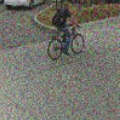

We have the follwing classes ['Bicycle', 'Bridge', 'Bus', 'Car', 'Chimney', 'Crosswalk', 'Hydrant', 'Motorcycle', 'Other', 'Palm', 'Stair', 'Traffic Light']
Each class gets an index value {'Bicycle': 0, 'Bridge': 1, 'Bus': 2, 'Car': 3, 'Chimney': 4, 'Crosswalk': 5, 'Hydrant': 6, 'Motorcycle': 7, 'Other': 8, 'Palm': 9, 'Stair': 10, 'Traffic Light': 11}
For the first image we have index 0


In [22]:
first_elem = train_val_dataset.__getitem__(0)
print(f"An element of a dataset contains {len(first_elem)} fields. (should be 2). The first field is an image, the second value is its corresponding label \n")

# the first index should be a tensor representation of an image
print("tensor of first image", first_elem[0], "\n")

print("image should be of shape 3,size,size: ", first_elem[0].shape)

# convert tensor back to a PIL image and visualize it with display()
display(transforms.ToPILImage()(first_elem[0]))
# Each folder is a class
classes = train_val_dataset.classes
print("We have the follwing classes", classes)

# Each classname is assigned an index
class_names = train_val_dataset.class_to_idx
print("Each class gets an index value", class_names)

# the second index is the numerical value of our label taken from the folder name
print(f"For the first image we have index {first_elem[1]}")

Split this dataset into a training set and a validation set.
For this you can use [random_split](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

In this example we will use 10% of the dataset for training and 90% for validation. You should change this percentage to a reasonable value
Remember overfitting and underfitting

In [23]:
train_percentage = 0.9 # how much of the dataset should be used for training --> change this value

no_train_images = int(train_val_length * train_percentage)
no_valid_images = train_val_length - no_train_images

train_dataset, valid_dataset = random_split(dataset=train_val_dataset, lengths=[no_train_images ,no_valid_images], generator=torch.Generator().manual_seed(42))

print(f"we divided the {len(train_val_dataset)} labeled images into {len(train_dataset)} training images and {len(valid_dataset)} validation images")

we divided the 3000 labeled images into 2700 training images and 300 validation images


Let's Create [Dataloaders](https://pytorch.org/docs/stable/data.html)
Dataloaders loads our data in batches and faster so out training speed increases.

The important arguments of the Dataloader are `dataset, batch_size, shuffle and  num_workers`
We are already giving the argument for dataset, you should choose fitting values for the other arguments

Let's create dataloaders for train and test

In [24]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) # You are free to add values for other arguments
valid_loader = DataLoader(dataset=valid_dataset, batch_size=64, shuffle=True)

Lets visualize images from the train loader

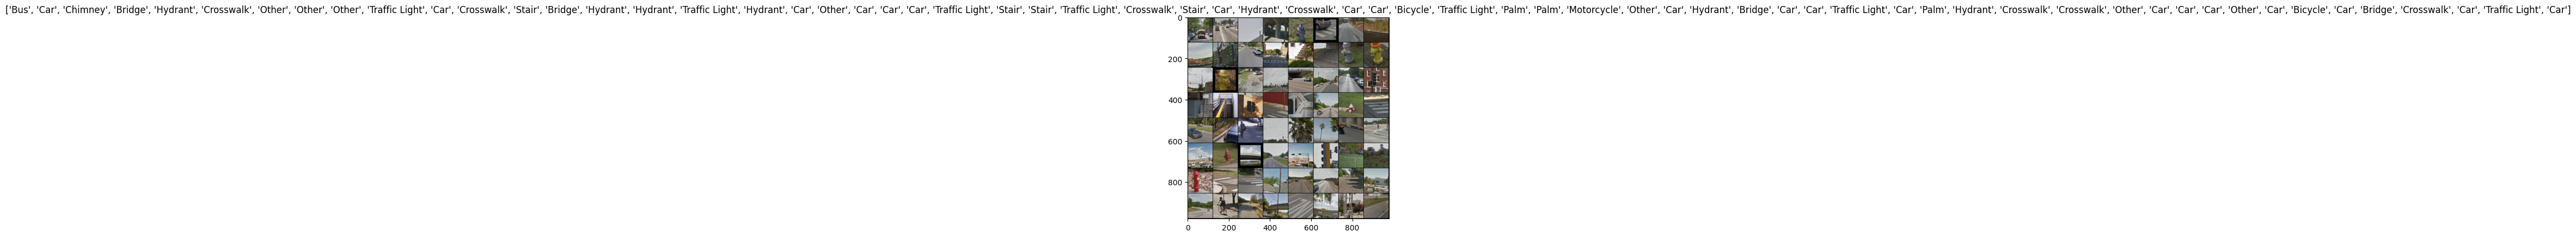

In [25]:
def vis_batch(loader):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1,2,0))
        plt.title(label)

    for batch_inputs, labels in loader:
        grid = torchvision.utils.make_grid(batch_inputs)
        show(grid, label=[classes[int(labels[x])] for x in range(len(labels))])
        break
vis_batch(train_loader)

Correct model

In [26]:
# ResNet18 model
import torch
import torch.nn as nn
import torchvision.models as models

# define number of training epochs and the data iterator
num_epochs = 7

# Loading the pretrained Inception v3 model
model = models.resnet18(pretrained=True)

# Freezing all layers
for param in model.parameters():
    param.requiresGrad = False

# Replacing the last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 12)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.001)

# Train the model
for epoch in range(num_epochs):
    # Loop over the data iterator, and feed the inputs and labels to the model
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the training process
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
               .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 98.1MB/s]


NameError: name 'optim' is not defined

You should use a different model.
Also you should now train your model.

The following method should not be changed. It predicts the classes for each image in the test dataset and stores them in a .csv file.


In [ ]:
def create_result_file(model, test_dataset, classes): # DO NOT CHANGE THIS METHOD
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    keys = ["ImageName", *classes]

    prediction_dict = {key: [] for key in keys}
    names = test_dataset.imgs
    model.to(device)
    model.eval() # set model to evaluation mode.
    for i in range(len(test_dataset)):
        input = test_dataset.__getitem__(i)
        input = input[0].to(device).unsqueeze(0) # take image tensor and add batch dimension
        with torch.no_grad(): # don't calculate gradients
            outputs = model(input).cpu().squeeze().numpy() # get prediction for input image
            prediction_dict["ImageName"].append(os.path.basename(names[i][0])) # save image name
            for class_idx, class_name in enumerate(classes): # save prediction for each class
                prediction_dict[class_name].append(outputs[class_idx])

    df = pd.DataFrame.from_dict(prediction_dict) # convert list into pandas dataframe
    df.to_csv("result.csv", index=False) # save dataframe as .csv

After training we can execute the
`
create_result_file(model, test_dataset, classes) method
`
In this given code we skip training and use our untrained model


In [ ]:
create_result_file(model, test_dataset, classes)

In [ ]:
# hier wurde eine aenderung gemacht

If you use Google colab, press the button `update/aktualisieren`
<div>
<img src=https://git.scc.kit.edu/vy9905/ml2images/-/raw/main/UpdateColab.jpg width="300">
<div>
You should see that the file result.csv was created. You can now download this file and upload it at

https://kit-ml1.streamlitapp.com/
